Chain using LangGraph

- How to use chat messages in our graph state
- How to use chat models in graph nodes
- how to bind tools to our LLM in nodes
- how to execute the tools calls in graph nodes

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

groq_api_key = os.getenv('GROQ_API_KEY')

In [2]:
groq_api_key

'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'

### How to use chat messages in our graph state

In [3]:
from langchain_core.messages import HumanMessage, AIMessage , AnyMessage

In [4]:
messages = [AIMessage(content='Please tell me how I can help you?' , name = 'LLMModel')]

In [5]:
messages.append(HumanMessage(content='I want to learn programming', name='Ankur'))

In [6]:
messages

[AIMessage(content='Please tell me how I can help you?', additional_kwargs={}, response_metadata={}, name='LLMModel'),
 HumanMessage(content='I want to learn programming', additional_kwargs={}, response_metadata={}, name='Ankur')]

In [7]:
messages.append(AIMessage(content='Which programming language you want to learn?' , name = 'LLMModel'))

In [8]:
messages

[AIMessage(content='Please tell me how I can help you?', additional_kwargs={}, response_metadata={}, name='LLMModel'),
 HumanMessage(content='I want to learn programming', additional_kwargs={}, response_metadata={}, name='Ankur'),
 AIMessage(content='Which programming language you want to learn?', additional_kwargs={}, response_metadata={}, name='LLMModel')]

In [9]:
messages.append(HumanMessage(content='I want to learn Python', name='Ankur'))

In [10]:
from pprint import pprint

In [11]:
for message in messages:
    message.pretty_print()

================================== Ai Message ==================================
Name: LLMModel

Please tell me how I can help you?
================================ Human Message =================================
Name: Ankur

I want to learn programming
================================== Ai Message ==================================
Name: LLMModel

Which programming language you want to learn?
================================ Human Message =================================
Name: Ankur

I want to learn Python


#### Chat Model

In [12]:
from langchain_groq import ChatGroq
llm = ChatGroq(model = 'qwen-qwq-32b')
result = llm.invoke(messages)

In [13]:
result.pretty_print()

================================== Ai Message ==================================


<think>
Okay, the user wants to learn Python. Let me start by breaking down the best approach for a beginner.

First, I should outline the basics they need to cover. The fundamentals like syntax, variables, data types, and control structures are essential. Maybe suggest starting with a simple "Hello, World!" to get them going.

Then, they'll need to set up their environment. Mention Python's official website for installation, and maybe recommend an IDE like PyCharm or VS Code. Oh, and Jupyter Notebooks could be good for interactive learning.

Next, resources. FreeCodeCamp and Codecademy offer structured courses. FreeCodeCamp's Python course is pretty comprehensive. I should list a few websites and maybe some books like "Automate the Boring Stuff" which is known for practical examples.

Projects are important for applying knowledge. Start with small projects like a calculator or to-do list, then move to m

In [14]:
result.response_metadata

{'token_usage': {'completion_tokens': 1856,
  'prompt_tokens': 57,
  'total_tokens': 1913,
  'completion_time': 4.522874341,
  'prompt_time': 0.005579812,
  'queue_time': 0.248224258,
  'total_time': 4.528454153},
 'model_name': 'qwen-qwq-32b',
 'system_fingerprint': 'fp_1e88ca32eb',
 'finish_reason': 'stop',
 'logprobs': None}

Tools

In [15]:
from langchain_core.tools import tool

In [16]:
@tool
def add(a:int , b:int) -> int:
    """Add a and b
    Args:
    a (int) : first int
    b (int) : second int
    
    Returns:
    int
    
    """

    return a+b
    

In [17]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001F249CBB010>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001F249DFBE10>, model_name='qwen-qwq-32b', model_kwargs={}, groq_api_key=SecretStr('**********'))

### Binding the tool



In [18]:
llm_with_tools = llm.bind_tools([add])

In [19]:
tool_calls = llm_with_tools.invoke(messages)

In [20]:
tool_calls.tool_calls

[]

In [21]:
tool_call = llm_with_tools.invoke([HumanMessage(content="What is 3 plus 4", name='Ankur')])

In [22]:
tool_call.tool_calls

[{'name': 'add',
  'args': {'a': 3, 'b': 4},
  'id': 'xdse9n8sf',
  'type': 'tool_call'}]

Implementing this with LangGraph

Create a State Schema with the help of messages

In [23]:
messages

[AIMessage(content='Please tell me how I can help you?', additional_kwargs={}, response_metadata={}, name='LLMModel'),
 HumanMessage(content='I want to learn programming', additional_kwargs={}, response_metadata={}, name='Ankur'),
 AIMessage(content='Which programming language you want to learn?', additional_kwargs={}, response_metadata={}, name='LLMModel'),
 HumanMessage(content='I want to learn Python', additional_kwargs={}, response_metadata={}, name='Ankur')]

In [24]:
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages


In [25]:
### State Schema

class State(TypedDict):
    messages : Annotated[list[AnyMessage], add_messages] 

### Understanding of how reducer function works

In [26]:
initial_message = [AIMessage(content='Please tell me how I can help you?'),
                   HumanMessage(content='I want to learn programming')]

In [27]:
ai_message = [AIMessage(content='Which language you want to learn')]

In [28]:
add_messages(initial_message,ai_message)

[AIMessage(content='Please tell me how I can help you?', additional_kwargs={}, response_metadata={}, id='653619d9-bf15-4e56-9c79-1bc4d9da53e1'),
 HumanMessage(content='I want to learn programming', additional_kwargs={}, response_metadata={}, id='07d68565-897a-4e1f-b095-79701d8686cc'),
 AIMessage(content='Which language you want to learn', additional_kwargs={}, response_metadata={}, id='46dff3c3-ce6f-41b1-bc00-4f551ae3f9a9')]

### Create a node 

In [29]:
def llm_tool(state:State):
    return {'messages' : [llm_with_tools.invoke(state['messages'])]}

### Build the Graph

In [30]:
from langgraph.graph import START, END, StateGraph

In [31]:
graph = StateGraph(State)

In [32]:
graph.add_node("llm_tool" , llm_tool)

In [33]:
graph.add_edge(START , "llm_tool")
graph.add_edge("llm_tool" , END)

In [34]:
graph_builder = graph.compile()

In [36]:
from IPython.display import Image, display

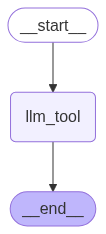

In [37]:
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [38]:
graph_builder.invoke({'messages' : "Hi my name is Ankur. I like to train on Gen AI"})

{'messages': [HumanMessage(content='Hi my name is Ankur. I like to train on Gen AI', additional_kwargs={}, response_metadata={}, id='ed9c2be6-41b6-472d-a66b-3ec706ba2e00'),
  AIMessage(content="Hello Ankur! Nice to meet you. It's great that you're interested in training on Gen AI. How can I assist you in your learning journey? If you have any questions or need help with specific topics, feel free to ask!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 253, 'prompt_tokens': 162, 'total_tokens': 415, 'completion_time': 0.588666505, 'prompt_time': 0.011668106, 'queue_time': 0.263339064, 'total_time': 0.600334611}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_a91d9c2cfb', 'finish_reason': 'stop', 'logprobs': None}, id='run--a19c15da-b3c8-49ce-9c9e-039615f9f296-0', usage_metadata={'input_tokens': 162, 'output_tokens': 253, 'total_tokens': 415})]}

In [39]:
graph_builder.invoke({'messages' : "What is one plus one"})

{'messages': [HumanMessage(content='What is one plus one', additional_kwargs={}, response_metadata={}, id='0f76762d-fa10-4f13-9afe-4e5afafff76b'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'tf6ph9d2y', 'function': {'arguments': '{"a":1,"b":1}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 152, 'prompt_tokens': 153, 'total_tokens': 305, 'completion_time': 0.374369702, 'prompt_time': 0.01082999, 'queue_time': 0.246216936, 'total_time': 0.385199692}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_98b01f25b2', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--35470894-3f68-4dd6-99f7-e276b3ae9094-0', tool_calls=[{'name': 'add', 'args': {'a': 1, 'b': 1}, 'id': 'tf6ph9d2y', 'type': 'tool_call'}], usage_metadata={'input_tokens': 153, 'output_tokens': 152, 'total_tokens': 305})]}